In [2]:
pip install torch-geometric sgp4 networkx matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 11.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Total TLE entries loaded: 100
Total TLE entries loaded: 30


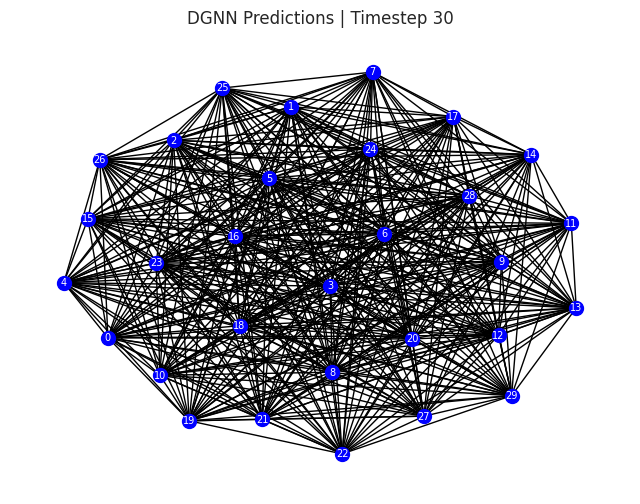

In [26]:
import numpy as np
from sgp4.api import Satrec, jday
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

def load_tle(file):
    tle_data = []
    satellite_names = []
    with open(file, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
        for i in range(0, len(lines) - 2, 3):
            if i + 2 < len(lines):
                if not lines[i + 1].startswith("1") or not lines[i + 2].startswith("2"):
                    continue
                satellite_names.append(lines[i])
                tle_data.append((lines[i + 1], lines[i + 2]))
    print(f"Total TLE entries loaded: {len(tle_data)}")
    return tle_data, satellite_names

def propagate_tle(tle_data, timesteps=60):
    frames = []
    for tle in tle_data:
        sat = Satrec.twoline2rv(tle[0], tle[1])
        frame = []
        jd, fr = jday(2000, 1, 1, 0, 0, 0)

        for t in range(timesteps):
            jd_timestep = jd + t * (1)
            _, position, _ = sat.sgp4(jd_timestep, fr)
            if position:
                frame.append(position)
            else:
                frame.append([None, None, None])
        frames.append(frame)

    return np.array(frames)

def prepare_graph_data(frames):
    graphs = []
    num_timestamps = frames.shape[1]

    for t in range(num_timestamps):
        positions_at_timestep = frames[:, t]
        num_nodes = len(positions_at_timestep)

        edge_index = torch.tensor(
            [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j],
            dtype=torch.long
        ).t().contiguous()

        x = torch.tensor(positions_at_timestep, dtype=torch.float)
        graphs.append(Data(x=x, edge_index=edge_index))

    return graphs

class DGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

def train_model(graphs, epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DGNN(input_dim=3, hidden_dim=16, output_dim=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        for graph in graphs:
            graph = graph.to(device)
            optimizer.zero_grad()
            output = model(graph)
            loss = criterion(output, graph.x)
            loss.backward()
            optimizer.step()
    return model

def generate_predictions(model, graphs):
    model.eval()
    with torch.no_grad():
        predictions = []
        for i, graph in enumerate(graphs):
            output = model(graph).cpu().numpy()
            predictions.append(output)
    return np.array(predictions)


def create_graph_animation(frames, satellite_names, title, save_path, collision_threshold=1.0):
    collision_detected = False

    def create_graph(frames, timestep):
        nonlocal collision_detected
        G = nx.Graph()

        for i, pos in enumerate(frames[timestep]):
            if None not in pos:
                G.add_node(i, pos=pos, name=satellite_names[i])
                for j in range(i + 1, len(frames[timestep])):
                    if None not in frames[timestep][j]:
                        distance = np.linalg.norm(np.array(pos) - np.array(frames[timestep][j]))
                        if distance < collision_threshold:
                            print(f"Collision detected between {satellite_names[i]} and {satellite_names[j]} at timestep {timestep}")
                            collision_detected = True
                        G.add_edge(i, j)

        return G

    def animate(timestep):
        ax.clear()
        if timestep >= len(frames) - 1:
            if not collision_detected:
                print("No collision detected in the entire animation.")
            return
        G = create_graph(frames, timestep)
        pos = nx.spring_layout(G)
        nx.draw(G, pos, ax=ax, with_labels=True, node_size=100, node_color="blue", edge_color="black" ,font_color='white',font_size=7)

        ax.set_title(f"{title} | Timestep {timestep + 1}")

    fig, ax = plt.subplots(figsize=(8, 6))
    ani = FuncAnimation(fig, animate, frames=min(frames.shape[1], len(frames)), interval=200)
    ani.save(save_path, writer="ffmpeg", fps=4)


tle_data, satellite_names = load_tle("/kaggle/input/datafortraining/Data.txt")
frames = propagate_tle(tle_data, timesteps=40)
graphs = prepare_graph_data(frames)

model = train_model(graphs, epochs=100)

tle_test_data, satellite_names = load_tle("/kaggle/input/short-dataset/Short Data.txt")
test_frames = propagate_tle(tle_test_data, timesteps=40)
test_graphs = prepare_graph_data(test_frames)
frame_list = generate_predictions(model, test_graphs)

create_graph_animation(frame_list, satellite_names, "DGNN Predictions", "dgnn_predictions.mp4")

In [4]:
import numpy as np
from sgp4.api import Satrec, jday
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def propagate_tle(tle_data, timesteps=40):
    frames = []
    for tle in tle_data:
        sat = Satrec.twoline2rv(tle[0], tle[1])
        frame = []
        jd, fr = jday(2000, 1, 1, 0, 0, 0)

        for t in range(timesteps):
            jd_timestep = jd + t * (1 / 1440)
            _, position, _ = sat.sgp4(jd_timestep, fr)
            if position:
                frame.append(position)
            else:
                frame.append([None, None, None])
        frames.append(frame)

    frames = np.array(frames)
    frames = np.nan_to_num(frames, nan=0.0)
    return frames

from sklearn.preprocessing import StandardScaler

def normalize_frames(frames):
    scaler = StandardScaler()
    frames_reshaped = frames.reshape(-1, frames.shape[-1])
    frames_normalized = scaler.fit_transform(frames_reshaped)
    return frames_normalized.reshape(frames.shape), scaler

def prepare_graph_data(frames):
    graphs = []
    num_timestamps = frames.shape[1]

    for t in range(num_timestamps):
        positions_at_timestep = frames[:, t]
        num_nodes = len(positions_at_timestep)

        edge_index = torch.tensor(
            [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j],
            dtype=torch.long
        ).t().contiguous()

        x = torch.tensor(positions_at_timestep, dtype=torch.float)
        x = torch.nan_to_num(x, nan=0.0)
        graphs.append(Data(x=x, edge_index=edge_index))

    return graphs

class DGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.nan_to_num(x, nan=0.0)
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return torch.nan_to_num(x, nan=0.0)

def train_model(graphs, epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DGNN(input_dim=3, hidden_dim=16, output_dim=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = torch.nn.HuberLoss(delta=1.0)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for graph in graphs:
            graph = graph.to(device)
            optimizer.zero_grad()
            output = model(graph)
            loss = criterion(output, graph.x)
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
    return model

def generate_predictions(model, graphs):
    model.eval()
    predictions = []
    with torch.no_grad():
        for graph in graphs:
            graph = graph.to('cuda' if torch.cuda.is_available() else 'cpu')
            output = model(graph).cpu().numpy()
            predictions.append(output)
    predictions = np.array(predictions)
    return predictions

tle_data, satellite_names = load_tle("/kaggle/input/datafortraining/Data.txt")
frames = propagate_tle(tle_data, timesteps=40)
frames, scaler = normalize_frames(frames)
graphs = prepare_graph_data(frames)

model = train_model(graphs, epochs=100)

tle_test_data, satellite_names = load_tle("/kaggle/input/datafortraining/Data.txt")
test_frames = propagate_tle(tle_test_data, timesteps=40)
test_frames = scaler.transform(test_frames.reshape(-1, test_frames.shape[-1])).reshape(test_frames.shape)
test_graphs = prepare_graph_data(test_frames)

predictions = generate_predictions(model, test_graphs)
denormalized_predictions = scaler.inverse_transform(predictions.reshape(-1, 3))

print("Running Complete")

Total TLE entries loaded: 100
Total TLE entries loaded: 100
Running Complete



Overall Average Evaluation Metrics:
  Mean Squared Error (MSE): 0.9987
  Mean Absolute Error (MAE): 0.0975
  Accuracy: 99.0000%
  F1 Score: 1.0000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


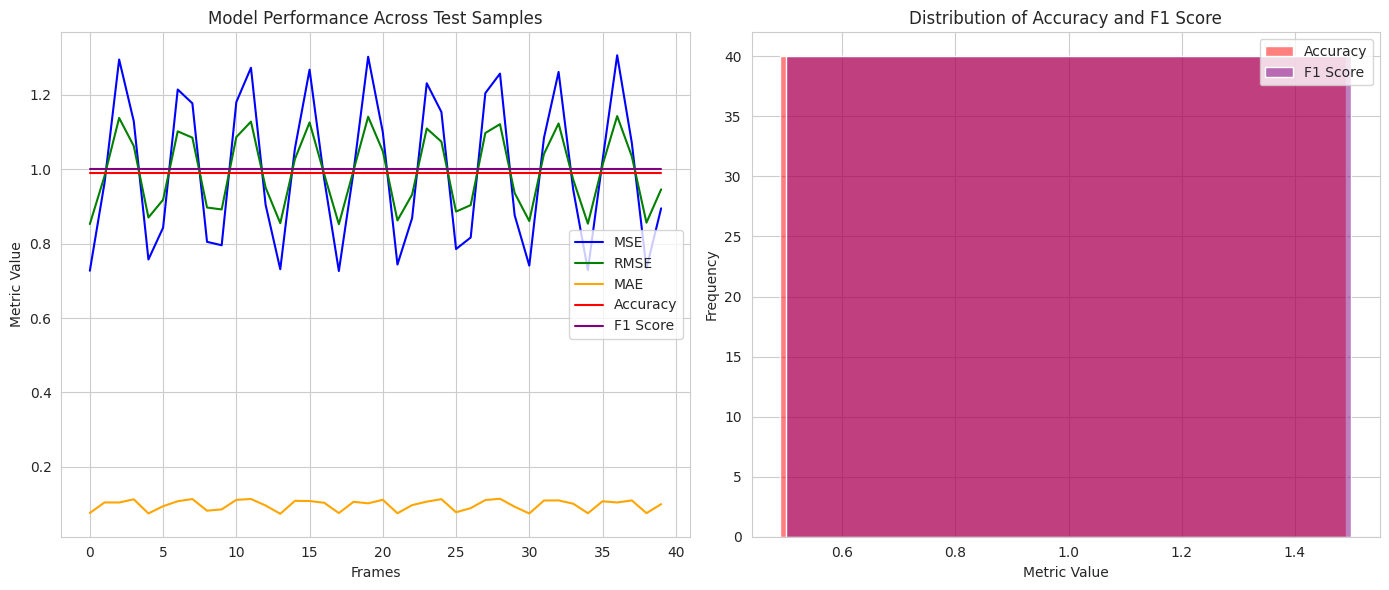

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score

def evaluate_model(model, graphs, threshold=0.1):
    model.eval()
    with torch.no_grad():
        metrics_per_sample = []
        
        for i, graph in enumerate(graphs):
            predicted_positions = model(graph)
            true_positions = graph.x

            predicted_positions_np = predicted_positions.cpu().numpy()
            true_positions_np = true_positions.cpu().numpy()

            mse = mean_squared_error(true_positions_np, predicted_positions_np)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(true_positions_np, predicted_positions_np)
            
            is_correct = np.all(np.abs(predicted_positions_np - true_positions_np) <= threshold, axis=1)
            accuracy = np.mean(is_correct)
            f1 = f1_score(is_correct, is_correct)

            metrics_per_sample.append((mse, rmse, mae, accuracy, f1))
        
        metrics_per_sample_np = np.array(metrics_per_sample)
        avg_mse = np.mean(metrics_per_sample_np[:, 0])
        avg_rmse = np.mean(metrics_per_sample_np[:, 1])
        avg_mae = np.mean(metrics_per_sample_np[:, 2])
        avg_accuracy = np.mean(metrics_per_sample_np[:, 3])
        avg_f1 = np.mean(metrics_per_sample_np[:, 4])

        print("\nOverall Average Evaluation Metrics:")
        print(f"  Mean Squared Error (MSE): {avg_mse:.4f}")
        print(f"  Mean Absolute Error (MAE): {avg_mae:.4f}")
        print(f"  Accuracy: {avg_accuracy:.4%}")
        print(f"  F1 Score: {avg_f1:.4f}")
        print("=" * 50)

        plt.figure(figsize=(14, 6))
        sns.set_style('whitegrid')

        plt.subplot(1, 2, 1)
        plt.plot(metrics_per_sample_np[:, 0], label='MSE', color='blue')
        plt.plot(metrics_per_sample_np[:, 1], label='RMSE', color='green')
        plt.plot(metrics_per_sample_np[:, 2], label='MAE', color='orange')
        plt.plot(metrics_per_sample_np[:, 3], label='Accuracy', color='red')
        plt.plot(metrics_per_sample_np[:, 4], label='F1 Score', color='purple')
        plt.title('Model Performance Across Test Samples')
        plt.xlabel('Frames')
        plt.ylabel('Metric Value')
        plt.legend()
        plt.tight_layout()
        plt.subplot(1, 2, 2)
        sns.histplot(metrics_per_sample_np[:, 3], color='red', kde=True, label='Accuracy')
        sns.histplot(metrics_per_sample_np[:, 4], color='purple', kde=True, label='F1 Score')
        plt.title('Distribution of Accuracy and F1 Score')
        plt.xlabel('Metric Value')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.tight_layout()
        plt.suptitle('', fontsize=16)
        plt.show()

evaluate_model(model, test_graphs, threshold=0.1)